# 3.8.3 Bungee Dunk

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [34]:
#@title
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

In simulating the Penny problem using differential equations and `solve_ivp`, we have made it possible to handle much more complex acceleration problems relatively easily.  

<br>

Why is it easier now? Addition! The Second Law of Motion connects a sum of forces to the second derivative of position (acceleration, that is):

<br>

$$\frac{d^2x}{dt^2} = \frac{\Sigma F}{m}$$

<br>

That sigma $\Sigma$ indicates addition, and this is not hard to handle in a simulation.  We can add whatever forces we'd like to our simulation--even if they change with time or position--and then use the differential equation to determine position and velocity for our object. 

<br>

We'll test this out by dunking a tea biscuit after plummeting down a couple hundred feet.

## Modeling and Implementing the Bungee Dunk

Let's say you want to set the world record for the highest "bungee dunk", which is a stunt in which a bungee jumper dunks a cookie in a cup of tea at the lowest point of a jump. Apparently, this is something you could try [(The video is worth a look)](https://https://www.youtube.com/watch?v=UBf7WC19lpw).

<br>

Since the record is 70 m, let's design a jump for 80 m. We'll start with the following modeling assumptions:

-   Initially the bungee cord hangs from a crane with the attachment point 80 m above a cup of tea.

-   Until the cord is fully extended, it applies no force to the jumper.  

-   After the cord is fully extended, it obeys Hooke's Law; that is, it applies a force to the jumper proportional to the extension of the cord beyond its resting length: $F = k\Delta x$

-   The mass of the jumper is 75 kg.

-   The jumper is subject to drag force so that their terminal velocity is 70 m/s; this is roughly the terminal velocity of a skydiver who is oriented vertically.

<br>

Our objective is to choose the length of the cord, `L`, and its spring
constant, `k`, so that the jumper falls all the way to the tea cup, but no farther!

### Parameters and the system

We'll create a `params` object to contain the quantities we'll need, including two guesses at the length of the rope $L$ and the spring coefficient $k$:


In [35]:
params = dict(y_attach = 80.0,   # m,
                 v_init = 0,     # m / s,
                 g = 9.8,        # m/s**2,
                 mass = 75.0,      # kg,
                 area = 0.3,     # m**2 (front facing area of object)
                 rho = 1.2,      # kg/m**3,
                 v_term = 70,    # m / s,
                 L = 25,         # m,
                 k = 40)         # N / m

Now here's a version of `make_system` that takes a `params` object as a parameter.  As in the Penny problem, `make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.  We'll assume that the jumper jumps from the same height that the cord is attached:

In [36]:
def make_system(params):
    y_attach, v_init, g, mass, area, rho, v_term, L, k = params.values()
    
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = pd.Series(dict(y=y_attach, v=v_init))
    t_end = 20

    return dict(y_attach=y_attach, v_init=v_init, g=g,
                mass=mass, area=area, rho=rho,
                v_term=v_term, L=L, k=k,
                C_d=C_d, init=init, t_end=t_end)

In [37]:
system = make_system(params)
system['C_d']

0.8333333333333334

The coefficient of drag is 0.83, which is a reasonable number given the situation.

### Computing forces

Now we need to calculate the forces on the jumper.  We'll start with `spring_force`, which computes the force of the cord on the jumper.  If the spring is not extended, the spring force is set to 0; if it is extended, the force is calculated using Hooke's Law.

In [38]:
def spring_force(y, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    
    Uses these variables from system|
    y_attach: height of the attachment point
    L: resting length of the cord
    k: spring constant of the cord
    
    returns: force in N
    """
    y_attach, L, k = system['y_attach'], system['L'], system['k']
    
    distance_fallen = y_attach - y
    if distance_fallen <= L:
        return 0
    
    extension = distance_fallen - L
    f_spring = k * extension
    return f_spring

The spring force is 0 until the 25 m cord is fully extended.  Remember that the total height is 80 m, so as long as the jumper's position is $y=55~m$ or above, the cord is not extended.

<br>When it is extended 1 m, the spring force is 40 N in the positive (upward) direction.

In [39]:
spring_force(55, system)

0

In [40]:
spring_force(54, system)

40.0

Now we can compute the drag force as a function of velocity.  Notice how we use the NumPy function `sign()` to make sure that the force is always in the direction opposite to the direction of motion. `sign()` returns a value of either 1.0 or -1.0 (depending on the value used as an argument):

In [41]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object

    returns: drag force
    """
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    
    f_drag = -np.sign(v) * ((1/2) * rho * v**2 * C_d * area) 
    return f_drag

We can check the internal validity of this function by making sure that when the acceleration created by drag at the terminal velocity is equal and opposite to the acceleration created by gravity.  Here's the drag force at 70 meters per second.

In [42]:
v = -70
f_drag = drag_force(v, system)
a_drag = f_drag / system['mass']
a_drag

9.8

It checks out OK!

### The slope function

Now we can sum our forces in the slope function and determine the overall acceleration using the Second Law and addition:

In [43]:
def slope_func(t, state, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    mass, g = system['mass'], system['g']
    
    a_gravity = -g
    a_drag = drag_force(v, system) / mass
    a_spring = spring_force(y, system) / mass
    
    dvdt = a_gravity + a_drag + a_spring
    
    return v, dvdt

As always, let's test the slope function with the initial parameters.  Just as the jumper jumps from the platform, velocity should be zero and the acceleration equal to gravitational acceleration:

In [44]:
slope_func(0, system['init'], system)

(0.0, -9.8)

## Analyzing the Bungee Dunk

### Finding the minimum position

Our central aim is to find the $L$ and $k$ values that will allow our jumper to reach 80 m at the bottom of the jump, which would allow her to dunk her tea biscuit.   So let's use `run_solve_ivp` and take a look at the position results:

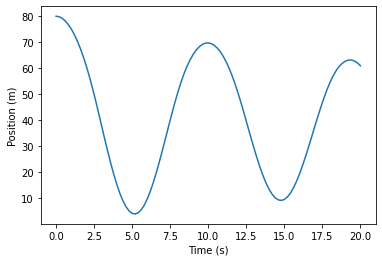

In [45]:
results, details = run_solve_ivp(system, slope_func)
results.y.plot(xlabel='Time (s)',
             ylabel='Position (m)');

After reaching the lowest point, the jumper springs back almost to almost 70 m and oscillates several times.  That looks like more oscillation that we expect from an actual jump, which suggests that there is some dissipation of energy in the real world that is not captured in our model.  To improve the model, that might be a good thing to investigate.

<br>

But since we are primarily interested in the initial descent, the model might be good enough for now.  We can use the built-in function `min()` to find the lowest point:

In [46]:
min(results.y)

4.077948877371114

At the lowest point, the jumper is still too high, so we'll need to increase `L` or decrease `k`.

Just for funsies, let's plot the velocity as a function of time:

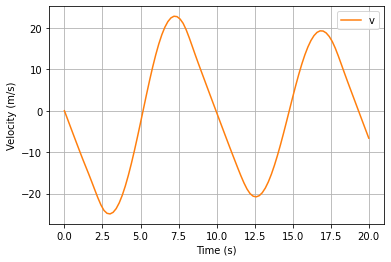

In [47]:
results.v.plot(color='C1', label='v', xlabel='Time (s)',
                   ylabel='Velocity (m/s)', legend=True, grid=True);

Notice that while the oscillation in this plot is similar to that in the position plot, it is shifted in time: when the jumper reaches the lowest elevation at about 5.0 s, the velocity is at 0.0.


## Solving for length

We could find the proper $L$ by the "guess-and-check" method, but we have tools that are more efficient and accurate than that.  Let's use `root_scalar()` to find the optimal length $L$.

<br> `root_scalar()` requires an error function, and it will find the parameter that makes the error function equal zero.  This is perfect, because we want our minimum elevation to be equal to zero:

In [59]:
def error_func(L, system):
    system['L'] = L
    results, details = run_solve_ivp(system,slope_func)
    y_final = min(results.y)
    return y_final

Let's test the error function with the value of $L$ that we used above.  We should get the same minimum value (~4.1 m):

In [60]:
# Test your error function
# Enter '25' as the 'L' value and make sure it gives you a value
# around 4-5 m

system1 = make_system(params)
error_func(25.0,system)

4.077948877371114

Now we can pull `error_func` into `root_scalar`, and it should find the value of $L$ that will optimize the length of our cord.   Since `root_scalar` needs a 'bracket' that gives a negative and a positive result, we'll give it a two lengths for $L$, one that we know is too short and one that is too long:

In [65]:
res1 = root_scalar(error_func, system1, bracket=[25,80])
res1.root

28.178569349001442

And now we can see that our cord has the ideal length to dip our biscuit into a cup of piping hot British tea:

0.00046725896386190513


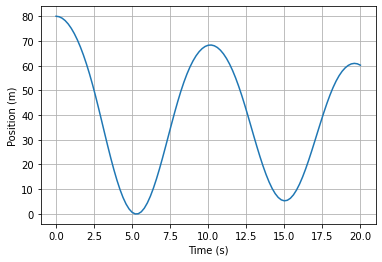

In [68]:
params_opt = params.copy()
params_opt.update(dict(L = res1.root))
system_opt = make_system(params_opt)
results_opt, details = run_solve_ivp(system_opt,slope_func)
print(min(results_opt.y))
results_opt.y.plot(xlabel='Time (s)', grid=True,
             ylabel='Position (m)');

## Exercises

### Exercise 1

Below this exercise is a copy of the function `spring_force(y,system)` so you can easily look at it.  Answer the following questions about the function, remembering that it gets called at every time step:

✅ ✅ A. What is the variable `y`?

✅ ✅ Answer here.

✅ ✅ B. What does `distance_fallen` represent in the physical system?

✅ ✅ Answer here

✅ ✅ C. What purpose do lines 15-16 serve?  Why does it return `0` if line 16 is true?

✅ ✅ Answer here

✅ ✅ D. What does the variable `extension` represent in the physical system?

✅ ✅ Answer here

✅ ✅ E. What does this function return?  Where is the function called?

✅ ✅ Answer here

In [ ]:
def spring_force(y, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    
    Uses these variables from system|
    y_attach: height of the attachment point
    L: resting length of the cord
    k: spring constant of the cord
    
    returns: force in N
    """
    y_attach, L, k = system['y_attach'], system['L'], system['k']
    
    distance_fallen = y_attach - y
    if distance_fallen <= L:
        return 0
    
    extension = distance_fallen - L
    f_spring = k * extension
    return f_spring